# Playing 2048 using Reinforcement Learning

### Scope:
This project aims to build a Deep Learning Model that plays the popular puzzle game '2048'.

The game environment is implemented in python.

I utilized Reinforcement Learning, specifically Deep Q-Learning using an epsilon greedy policy to train the model that controls the agent.

The model is a non-Sequential Convolutional Neural Network which takes the game board as input and outputs the Q-Values of each of the available actions.



In [1]:
import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
import numpy as np
from PIL import Image
import numpy as np
import tensorflow as tf
from collections import deque
import json
import random
import os
import pandas as pd
import matplotlib.animation as animation

2023-07-02 18:22:12.503705: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/usr/lib/python3.11/site-packages/h5py/__init__.py:36: UserWarning: h5py is running against HDF5 1.14.1 when it was built against 1.14.0, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Graphics:

In [5]:
TILE_COLORS = {
    0: '#BBADA4',
    2: '#EEE4DA',
    4: '#ECE0CA',
    8: '#F2B17B',
    16: '#F59763',
    32: '#F57C5F',
    64: '#F8663F',
    128: '#EDCE71',
    256: '#EDCC61',
    512: '#ECC850',
    1024: '#EDC53F',
    2048: '#EEC22E',
    4096: '#3D3A33',
    8192: '#3D3A33',
    16384: '#3D3A33',
    32768: '#3D3A33',
    65536: '#3D3A33'
}


def display_board(board, score):
    # Create a figure and axis
    fig, ax = plt.subplots()

    # Plot the data with corresponding colors
    for i in range(len(board)):
        for j in range(len(board[i])):
            value = board[i][j]
            color = TILE_COLORS.get(value, 'white')
            rect = plt.Rectangle((j, i), 1, 1, facecolor=color, edgecolor='black')
            ax.add_patch(rect)
            ax.text(j + 0.5, i + 0.5, str(value), ha='center', va='center', fontsize=20)

    # Set the aspect ratio to equal
    ax.set_aspect('equal')

    # Set the x-axis and y-axis limits
    ax.set_xlim([0, 4])
    ax.set_ylim([0, 4])

    # Remove the axis ticks and labels
    ax.set_xticks([])
    ax.set_yticks([])
    ax.axis('off')

    canvas = FigureCanvas(fig)
    canvas.draw()
    pil_image = Image.frombytes('RGB', canvas.get_width_height(), canvas.tostring_rgb())
    plt.close(fig)
    plt.clf()

    return pil_image

def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, title='game', repeat=True, interval=500):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()

    writer = animation.FFMpegWriter(fps=60)
    path = f"./video/{title}.mp4"
    anim.save(path, writer=writer)
    return anim

def render_one_episode(episode):
    path = f'video/episode_{episode}/'
    frames = []
    length = len(os.listdir(path))

    for i in range(1, length):
        file_path = os.path.join(path, f'frame_{i}.png')
        image = Image.open(file_path)
        frames.append(image)

    anim = game_animation.plot_animation(frames, f'episode_{episode}')

def save_frames(frames, title):
    pathname = f'video/{title}'
    if not os.path.exists(pathname):
        os.mkdir(pathname)
    for i, frame in enumerate(frames):
        frame.save(f'{pathname}/frame_{i}.png')

def save_results(n_episodes, n_steps, best_score, best_step):
    with open('results.txt', 'w') as f:
        f.write(f"Episodes: {n_episodes}\nSteps: {n_steps}\nBest Score: {best_score}\nBest Step: {best_step}")
    f.close()

def log(episode, score, df):
    df = df.append({'episode': episode, 'score': score}, ignore_index=True)
    return df



### Game Logic:

In [6]:
class game:
    def __init__(self, SIZE=4, output='1D'):
        self.SIZE = SIZE

        self.board = [[0] * SIZE for _ in range(SIZE)]
        self.prev_board = [[0] * SIZE for _ in range(SIZE)]

        self.score = 0
        self.penalty = 0
        self.output_shape = output
        self.make()

    def make(self):
        for i in range(self.SIZE):
            for j in range(self.SIZE):
                self.board[i][j] = 0
        self.next_turn()

    def reset(self):
        if self.output_shape == '1D':
            obs = [item for sublist in self.board for item in sublist]
        elif self.output_shape == '2D':
            obs = self.board
        obs = np.array(obs, dtype=np.float32)

        old_score = self.score

        self.score = 0
        self.penalty = 0
        self.make()
        self.prev_board = self.board
        return obs

    def render(self):
        board = self.board
        score = self.score
        return display_board(board, score)

    def print(self):
        for i in range(len(self.board)):
            for j in range(len(self.board[i])):
                if self.board[i][j] == 0:
                    print("  *  ", end="")
                else:
                    print(f"  {self.board[i][j]}  ", end="")
            print()
        print("Score:", self.score)
        print()


    def board_full(self):
        count = 0
        for i in range(len(self.board)):
            for j in range(len(self.board[i])):
                if self.board[i][j] != 0:
                    count += 1

        if count == 16:
            return True
        else:
            return False

    def empty_cells(self):
        empty = []
        for i in range(len(self.board)):
            for j in range(len(self.board[i])):
                if self.board[i][j] == 0:
                    empty.append(self.board[i][j])
        return empty

    def next_turn(self):
        numbers = [2, 2, 2, 2, 2, 2, 2, 2, 4, 4]

        # find empty places on the board
        empty = []
        for i in range(len(self.board)):
            for j in range(len(self.board[i])):
                if self.board[i][j] == 0:
                    empty.append((i,j))

        if not empty:
            return

        # generate random cell position and random number
        random_cell = random.choice(empty)
        random_input = random.choice(numbers)

        self.board[random_cell[0]][random_cell[1]] = random_input


    def move_elements(self, ar):
        # move down empty cells
        for i in range(self.SIZE):
            for j in range(len(ar) - 1):
                while  j != len(ar) - 1 and ar[j + 1] == 0:
                    it = ar[j]
                    ar[j + 1] = it
                    ar[j] = 0
                    j += 1

        # merge cells
        i = len(ar) - 1
        while (i >= 1):
            if ar[i] == ar[i - 1] and ar[i] != 0:
                ar[i - 1] += ar[i]
                ar[i] = 0
                self.score += ar[i - 1]
                i -= 1
            i -= 1

        # move down empty cells
        for i in range(self.SIZE):
            for j in range(len(ar) - 1):
                while  j != len(ar) - 1 and ar[j + 1] == 0:
                    it = ar[j]
                    ar[j + 1] = it
                    ar[j] = 0
                    j += 1


    def move(self, action):
        ar = [0] * self.SIZE

        if int(action) == 0:
            # move left
            for i in range(self.SIZE):
                for j in range(self.SIZE - 1, -1, -1):
                    ar[self.SIZE - 1 - j] = self.board[i][j]
                self.move_elements(ar)
                for j in range(self.SIZE - 1, -1, -1):
                    self.board[i][j] = ar[self.SIZE - 1 - j]

        elif int(action) == 1:
            # move down
            for j in range(self.SIZE):
                for i in range(self.SIZE):
                    ar[i] = self.board[i][j]
                self.move_elements(ar)
                for i in range(self.SIZE):
                    self.board[i][j] = ar[i]

        elif int(action) == 2:
            # move up
            for j in range(self.SIZE):
                for i in range(self.SIZE - 1, -1, -1):
                    ar[self.SIZE - 1 - i] = self.board[i][j]
                self.move_elements(ar)
                for i in range(self.SIZE - 1, -1, -1):
                    self.board[i][j] = ar[self.SIZE - 1 - i]

        elif int(action) == 3:
            # move right
            for i in range(self.SIZE):
                for j in range(self.SIZE):
                    ar[j] = self.board[i][j]
                self.move_elements(ar)
                for j in range(self.SIZE):
                    self.board[i][j] = ar[j]

    def is_same(self):
        for row1, row2 in zip(self.board, self.prev_board):
            for element1, element2 in zip(row1, row2):
                if element1 != element2:
                    return False

        return True

    def game_over(self):
        board_cp = [row[:] for row in self.board]
        prev_board_cp = [row[:] for row in self.prev_board]
        score_cp = self.score

        if self.board_full():
            self.move(0)
            self.move(1)
            self.move(2)
            self.move(3)
            if self.is_same():
                self.board = board_cp
                self.prev_board = prev_board_cp
                return True

        self.board = [row[:] for row in board_cp]
        self.prev_board = [row[:] for row in prev_board_cp]
        self.score = score_cp
        return False

    def save(self):
        for i in range(self.SIZE):
            for j in range(self.SIZE):
                self.prev_board[i][j] = self.board[i][j]


    def step(self, action):
        prev_score = self.score
        done = 0


        self.save()
        self.move(action)
        if not self.is_same():
            self.next_turn()
            self.penalty = 0
        else:
            self.penalty += 0.1 * self.score

        if self.output_shape == '1D':
            obs = [item for sublist in self.board for item in sublist]
        elif self.output_shape == '2D':
            obs = self.board
        obs = np.array(obs, dtype=np.float32)

        if self.game_over():
            done = 1
            reward = 0
            return obs, reward, done, self.score

        reward = self.score - prev_score - self.penalty

        return obs, reward, done, self.score


#### The object of the game is to reach the highest number possible on the board. The agent can move all the numbers on the board by one space left, right, up or down. By moving two equal numbers cells into each other, we merge them.
#### Each turn, a new number (2 or 4) is added to a random space on the board.
#### The game is over when all 16 spaces are occupied and no other moves are possible (deadlock)
#### Everytime two cells are merged, their number value is added to the score. The score is the sum of all the number values of all the cells merged
#### Lets play a few turns

In [7]:
new_game = game(SIZE=4)

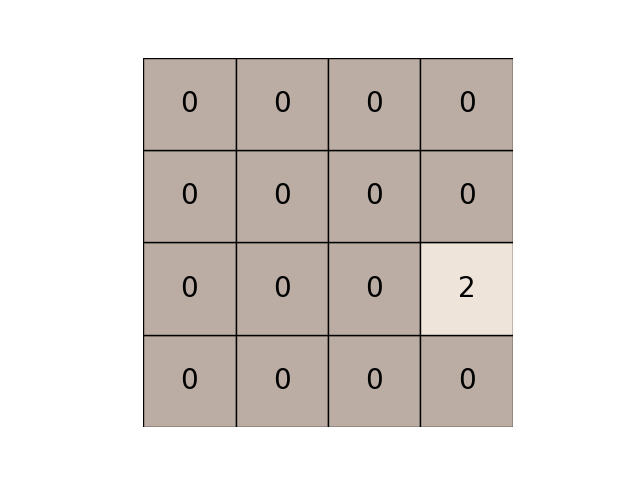

<Figure size 640x480 with 0 Axes>

In [8]:
new_game.render()

Moving up, down, left and then right

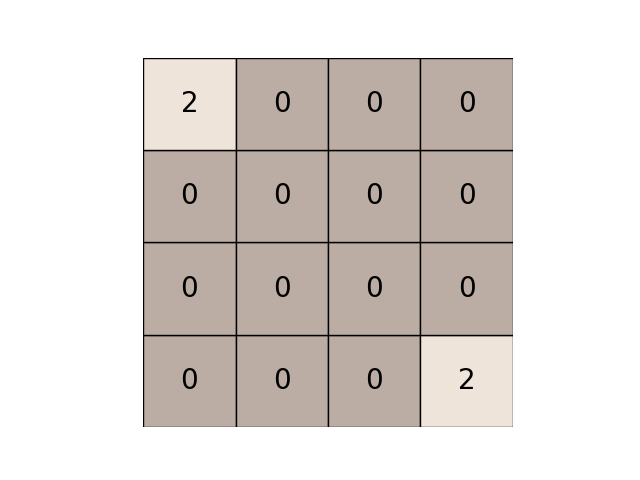

<Figure size 640x480 with 0 Axes>

In [9]:
# Up
new_game.step(2)
new_game.render()

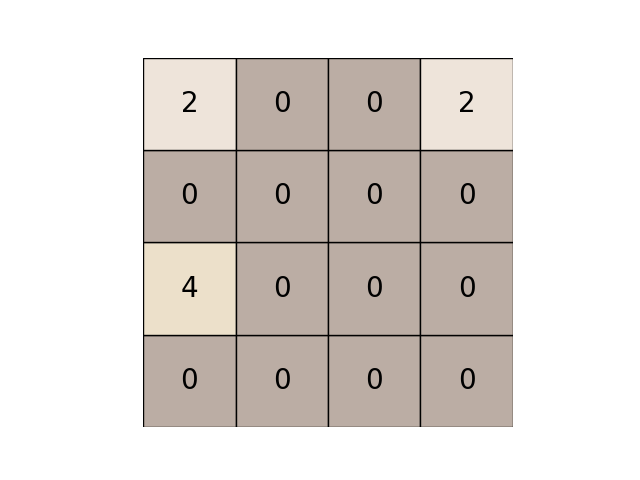

<Figure size 640x480 with 0 Axes>

In [10]:
# Down
new_game.step(1)
new_game.render()

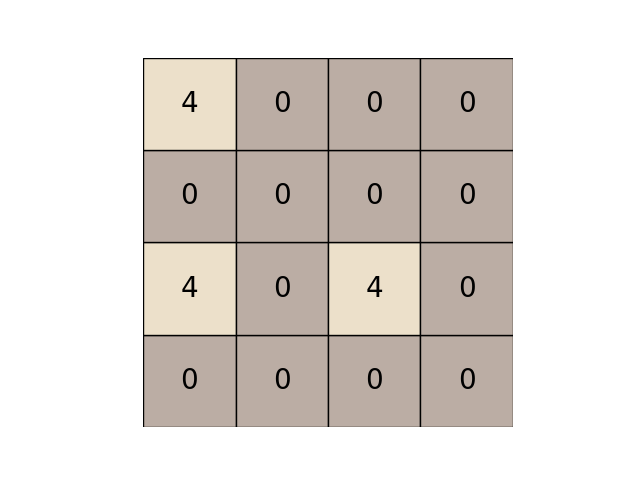

<Figure size 640x480 with 0 Axes>

In [11]:
# left
new_game.step(0)
new_game.render()

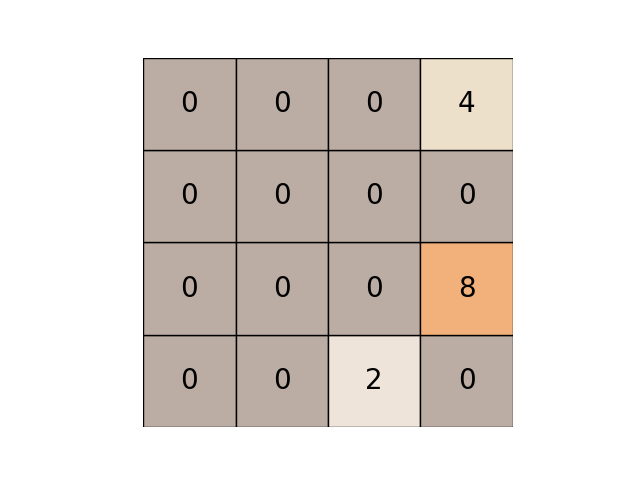

<Figure size 640x480 with 0 Axes>

In [12]:
# Right
new_game.step(3)
new_game.render()

In [13]:
new_game.score

12

An expert player is expected to use the symmetry of the board to create the biggest number possible.
Here's what a very good board (also a game over) looks like:

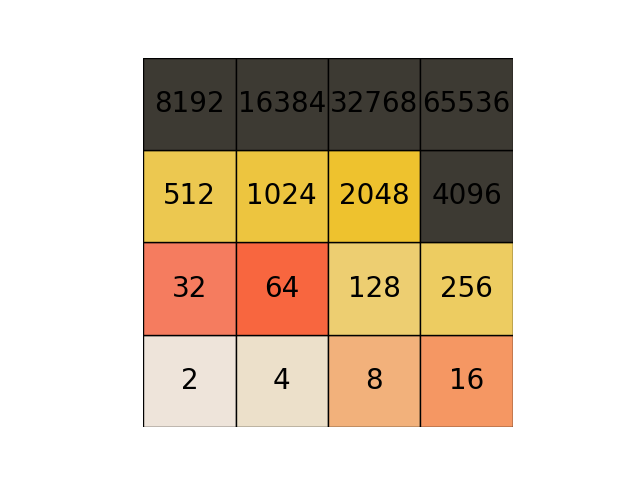

<Figure size 640x480 with 0 Axes>

In [14]:
new_game.board = [[2,4,8,16], [32,64,128,256], [512,1024,2048,4096], [8192, 16384,32768,65536]]
new_game.render()

The game is over because there is no empty cell and no two cells can be merged

### The Model

Due to dealing with images, convolutional layers are helpful. However, since we aim to preserve the detail of the board, which is critical, there are no pooling layers. Instead, the outputs of each of the convolutional layers are flattened and concatenated into a dense layer.

In [15]:
class Model:

    def __init__(self, input_shape=[16], n_outputs=4):
        self.input_shape = input_shape          # all state variables - env.observation_space.shape
        self.n_outputs = n_outputs              # approximate q-value for each action - 2 actions

    def build_model(self):
        inputs = tf.keras.layers.Input(shape=[16])

        reshape = tf.keras.layers.Reshape([4,4,1])(inputs)

        conv1 = tf.keras.layers.Conv2D(filters=64,
                                        kernel_size=(1,2),
                                        strides=1,
                                        padding='valid',
                                        activation='relu')(reshape)
        conv2 = tf.keras.layers.Conv2D(filters=64,
                                        kernel_size=(2,1),
                                        strides=1,
                                        padding='valid',
                                        activation='relu')(reshape)
        conv11 = tf.keras.layers.Conv2D(filters=128,
                                        kernel_size=(1,2),
                                        strides=1,
                                        padding='valid',
                                        activation='relu')(conv1)
        conv12 = tf.keras.layers.Conv2D(filters=128,
                                        kernel_size=(2,1),
                                        strides=1,
                                        padding='valid',
                                        activation='relu')(conv1)
        conv21 = tf.keras.layers.Conv2D(filters=128,
                                        kernel_size=(1,2),
                                        strides=1,
                                        padding='valid',
                                        activation='relu')(conv2)
        conv22 = tf.keras.layers.Conv2D(filters=128,
                                        kernel_size=(2,1),
                                        strides=1,
                                        padding='valid',
                                        activation='relu')(conv2)

        flatten = tf.keras.layers.Flatten()

        hidden1 = tf.keras.layers.Flatten()(conv1)
        hidden2 = tf.keras.layers.Flatten()(conv2)
        hidden11 = tf.keras.layers.Flatten()(conv11)
        hidden12 = tf.keras.layers.Flatten()(conv12)
        hidden21 = tf.keras.layers.Flatten()(conv21)
        hidden22 = tf.keras.layers.Flatten()(conv22)

        hidden = tf.concat([hidden1, hidden2, hidden11, hidden12, hidden21, hidden22], axis=1)
        outputs = tf.keras.layers.Dense(4, activation='relu')(hidden)

        model = tf.keras.Model(inputs=[inputs], outputs=[outputs])

        return model


In [16]:
new_model = Model().build_model()
new_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 16)]         0           []                               
                                                                                                  
 reshape (Reshape)              (None, 4, 4, 1)      0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 4, 3, 64)     192         ['reshape[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 3, 4, 64)     192         ['reshape[0][0]']                
                                                                                              

![graph-01.png](attachment:graph-01.png)

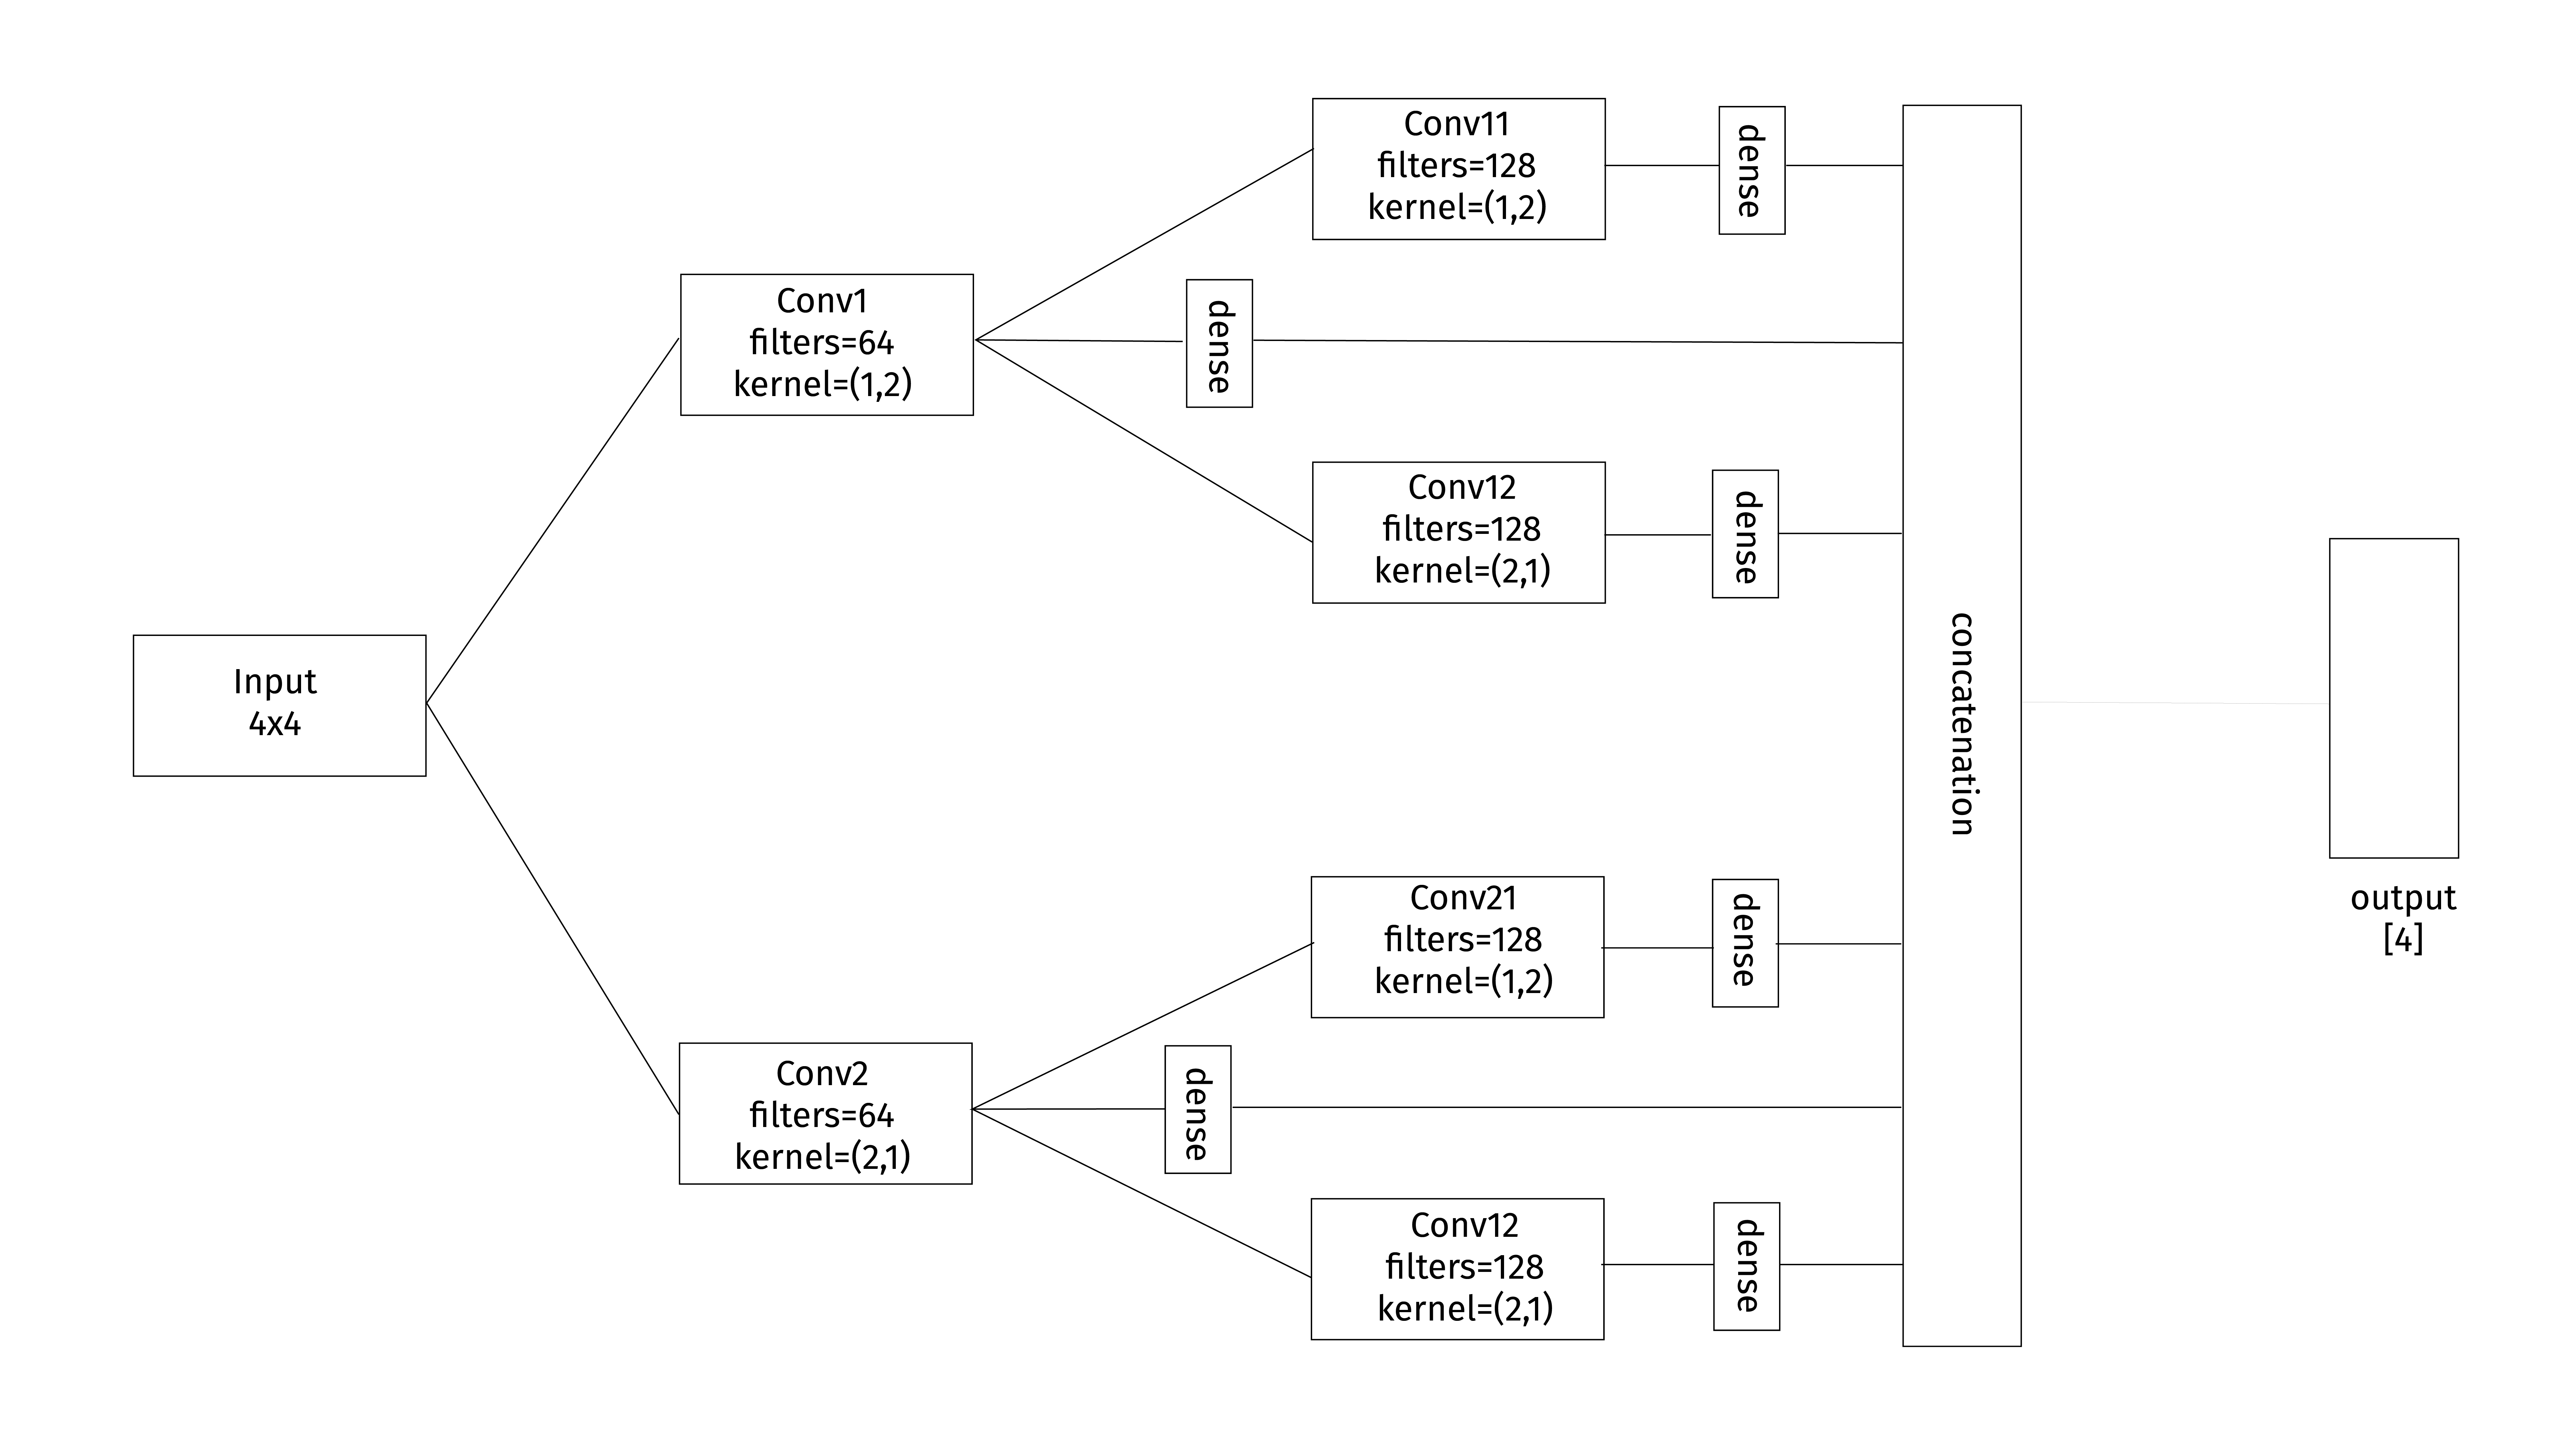

This network architecture is not of my own creation. I experimented with convolutional layers and dense layers, but due to lack of reliable hardware my creativity was limited, so I explored other people's work.
https://github.com/navjindervirdee is credited with this architecture, albeit his model is much larger in scale.

### Reinforcement Learning

We use three approaches to train the agent:
- **Deep Q Learning**:
  The NN is responsible for predicting the approximate future Q-Values of each action.
- **Fixed Q-value Targets**:
  We use two seperate NN. The first model is used to move the agent around (online model). This model learns throughout training. A second identical model, learns in 50-episode intervals and is used to predict the future Q-values of each action (target model). This is suppossed to produce more stable training.
- **Double DQN**:
  We use the online model to select the best agent actions, and the target model to predict the Q-values of these actions.

In [17]:
class Deep_Q_Policy():

    def __init__(self, n_outputs, model):
        self.n_outputs = n_outputs
        self.model = model
        self.replay_buffer = deque(maxlen=20000)

    def epsilon_greedy_policy(self, state, epsilon=0):
        if np.random.rand() < epsilon :
            return np.random.randint(self.n_outputs)                 # random action
        else:
            state = state.reshape(-1, state.shape[-1])
            Q_values = self.model.predict(state, verbose=0)[0]     # optimal action - highest q-value according to DQN
            return Q_values.argmax()

    def sample_experiences(self, batch_size):
        indices = np.random.randint(len(self.replay_buffer), size=batch_size)
        batch = [self.replay_buffer[index] for index in indices]
        return [np.array([experience[field_index] for experience in batch]) for field_index in range(6)]
                                # [states, actions, rewards, next_states, dones, scores]

    def play_one_step(self, env, state, epsilon):
        action = self.epsilon_greedy_policy(state, epsilon)
        next_state, reward, done, score = env.step(action)
        self.replay_buffer.append((state, action, reward, next_state, done, score))
        return next_state, reward, done, score

    def training_step(self, batch_size, discount_factor, optimizer, loss_fn):
        experiences = self.sample_experiences(batch_size)
        states, actions, rewards, next_states, dones, scores = experiences

        next_Q_values = self.model.predict(next_states, verbose=0)
        max_next_Q_values = next_Q_values.max(axis=1)

        runs = 1.0 - (dones)  # episode is not done or truncated
        target_Q_values = rewards + runs * discount_factor * max_next_Q_values
        target_Q_values = target_Q_values.reshape(-1, 1)

        mask = tf.one_hot(actions, self.n_outputs)
        with tf.GradientTape() as tape:
            all_Q_values = self.model(states)
            Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
            loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))

        grads = tape.gradient(loss, self.model.trainable_variables)
        optimizer.apply_gradients(zip(grads, self.model.trainable_variables))

    def clear_buffer(self):
        self.replay_buffer.clear()
        # self.replay_buffer = deque(maxlen=20000)

    def demo_play_one_step(self, env, state, epsilon):
        action = self.epsilon_greedy_policy(state, epsilon)
        next_state, reward, done, score = env.step(action)
        return next_state, reward, done, score

In [18]:
class Fixed_Targets_Policy():

    def __init__(self, n_outputs, model):
        self.n_outputs = n_outputs
        self.model = model
        self.target = tf.keras.models.clone_model(self.model)
        self.replay_buffer = deque(maxlen=20000)
        self.copy_weights()

    def epsilon_greedy_policy(self, state, epsilon=0):
        if np.random.rand() < epsilon :
            return np.random.randint(self.n_outputs)                 # random action
        else:
            # if len(state) == 4:
            #     state = [item for sublist in state for item in sublist]
            state = state.reshape(-1, state.shape[-1])
            Q_values = self.model.predict(state, verbose=0)[0]     # optimal action - highest q-value according to DQN
            return Q_values.argmax()

    def sample_experiences(self, batch_size):
        indices = np.random.randint(len(self.replay_buffer), size=batch_size)
        batch = [self.replay_buffer[index] for index in indices]
        return [np.array([experience[field_index] for experience in batch]) for field_index in range(6)]
                                # [states, actions, rewards, next_states, dones, scores]

    def play_one_step(self, env, state, epsilon):
        action = self.epsilon_greedy_policy(state, epsilon)
        next_state, reward, done, score = env.step(action)
        self.replay_buffer.append((state, action, reward, next_state, done, score))
        return next_state, reward, done, score

    def training_step(self, batch_size, discount_factor, optimizer, loss_fn):
        experiences = self.sample_experiences(batch_size)
        states, actions, rewards, next_states, dones, scores = experiences

        next_Q_values = self.target.predict(next_states, verbose=0)
        max_next_Q_values = next_Q_values.max(axis=1)

        runs = 1.0 - (dones)  # episode is not done or truncated
        target_Q_values = rewards + runs * discount_factor * max_next_Q_values
        target_Q_values = target_Q_values.reshape(-1, 1)

        mask = tf.one_hot(actions, self.n_outputs)
        with tf.GradientTape() as tape:
            all_Q_values = self.model(states)
            Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
            loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))

        grads = tape.gradient(loss, self.model.trainable_variables)
        optimizer.apply_gradients(zip(grads, self.model.trainable_variables))

    def clear_buffer(self):
        self.replay_buffer.clear()
        # self.replay_buffer = deque(maxlen=20000)

    def demo_play_one_step(self, env, state, epsilon):
        action = self.epsilon_greedy_policy(state, epsilon)
        next_state, reward, done, score = env.step(action)
        return next_state, reward, done, score

    def copy_weights(self):
        self.target.set_weights(self.model.get_weights())

In [19]:
class Double_DQN_Policy():

    def __init__(self, n_outputs, model):
        self.n_outputs = n_outputs
        self.model = model
        self.target = tf.keras.models.clone_model(self.model)
        self.replay_buffer = deque(maxlen=20000)
        self.copy_weights()

    def epsilon_greedy_policy(self, state, epsilon=0):
        if np.random.rand() < epsilon :
            return np.random.randint(self.n_outputs)                 # random action
        else:
            # if len(state) == 4:
            #     state = [item for sublist in state for item in sublist]
            state = state.reshape(-1, state.shape[-1])
            Q_values = self.model.predict(state, verbose=0)[0]     # optimal action - highest q-value according to DQN
            return Q_values.argmax()

    def sample_experiences(self, batch_size):
        indices = np.random.randint(len(self.replay_buffer), size=batch_size)
        batch = [self.replay_buffer[index] for index in indices]
        return [np.array([experience[field_index] for experience in batch]) for field_index in range(6)]
                                # [states, actions, rewards, next_states, dones, scores]

    def play_one_step(self, env, state, epsilon):
        action = self.epsilon_greedy_policy(state, epsilon)
        next_state, reward, done, score = env.step(action)
        self.replay_buffer.append((state, action, reward, next_state, done, score))
        return next_state, reward, done, score

    def training_step(self, batch_size, discount_factor, optimizer, loss_fn):
        experiences = self.sample_experiences(batch_size)
        states, actions, rewards, next_states, dones, scores = experiences

        next_Q_values = self.model.predict(next_states, verbose=0)
        best_next_actions = next_Q_values.argmax(axis=1)
        next_mask = tf.one_hot(best_next_actions, self.n_outputs).numpy()
        max_next_Q_values = (self.target.predict(next_states, verbose=0) * next_mask).sum(axis=1)

        runs = 1.0 - (dones)  # episode is not done or truncated
        target_Q_values = rewards + runs * discount_factor * max_next_Q_values
        target_Q_values = target_Q_values.reshape(-1, 1)

        mask = tf.one_hot(actions, self.n_outputs)
        with tf.GradientTape() as tape:
            all_Q_values = self.model(states)
            Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
            loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))

        grads = tape.gradient(loss, self.model.trainable_variables)
        optimizer.apply_gradients(zip(grads, self.model.trainable_variables))

    def clear_buffer(self):
        self.replay_buffer.clear()
        # self.replay_buffer = deque(maxlen=20000)

    def demo_play_one_step(self, env, state, epsilon):
        action = self.epsilon_greedy_policy(state, epsilon)
        next_state, reward, done, score = env.step(action)
        return next_state, reward, done, score

    def copy_weights(self):
        self.target.set_weights(self.model.get_weights())

### Training

We train for 700 episodes using each approach.

In [20]:
# helper function for visualizing results
def graph(df, title):
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=False, sharey=False)

    ax1.plot(df.episode, df.score)
    ax1.set_title('Score Per Episode')
    ax1.set_xlabel('Episodes')
    ax1.set_ylabel('Score')

    rolling = df.score.rolling(window=25).mean()
    ax2.plot(rolling)
    ax2.set_title('Rolling Average of 50 Episodes')
    ax2.set_xlabel('Episodes')
    ax2.set_ylabel('Score')

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()


In [21]:
SIZE = 4

In [22]:
def fixed_targets_train(log_df):
    env = game(SIZE, output='1D')
    obs = env.reset()

    np.random.seed(42)
    tf.random.set_seed(42)
    rewards = []
    best_score = 0
    n_episodes = 700
    n_steps = 10000

    batch_size = 32
    discount_factor = 0.90
    optimizer = tf.keras.optimizers.RMSprop(learning_rate=1e-2)
    loss_fn = tf.keras.losses.mean_squared_error

    # Model
    input_shape = [16]
    n_outputs = 4

    model = Model(input_shape, n_outputs)
    model = Model.build_model(model)

    # Learning Policy
    policy = Fixed_Targets_Policy(n_outputs, model)

    # Training
    for episode in range(n_episodes):
        obs = env.reset()

        for step in range(n_steps):
            epsilon = max(0.9 - episode / 900, 0.01)
            obs, reward, done, score = policy.play_one_step(env, obs, epsilon)

            if done:
                break

            if score >= best_score:
                best_weights = model.get_weights()
                best_score = score

            print(f"\rEpisode: {episode + 1}, Steps: {step + 1}, Score: {score}, eps: {epsilon:.3f}", end="")

        if episode > 100:
            policy.training_step(batch_size, discount_factor, optimizer, loss_fn)
            if episode % 50 == 0:
                policy.copy_weights()

        try:
            log_df = log(episode, score, log_df)
        except:
            pass

    return log_df

In [23]:
def deep_q_train(log_df):
    env = game(SIZE=SIZE, output='1D')
    obs = env.reset()

    np.random.seed(42)
    tf.random.set_seed(42)
    best_score = 0
    best_step = 0
    n_episodes = 700
    n_steps = 10000

    batch_size = 32
    discount_factor = 0.90
    optimizer = tf.keras.optimizers.RMSprop(learning_rate=1e-2)
    loss_fn = tf.keras.losses.mean_squared_error

    # Model
    input_shape = [SIZE*SIZE]
    n_outputs = SIZE

    model = Model(input_shape, n_outputs)
    model = Model.build_model(model)

    # Learning Policy
    policy = Deep_Q_Policy(n_outputs, model)

    # Training
    for episode in range(n_episodes):
        obs = env.reset()
        for step in range(n_steps):
            epsilon = max(0.9 - episode / 900, 0.01)
            obs, reward, done, score = policy.play_one_step(env, obs, epsilon)

            if done:
                break

            if score >= best_score:
                best_weights = model.get_weights()
                best_score = score

            print(f"\rEpisode: {episode + 1}, Steps: {step + 1}, Score: {score}, eps: {epsilon:.3f}", end="")

        if episode > 100:
            policy.training_step(batch_size, discount_factor, optimizer, loss_fn)

        try:
            log_df = log(episode, score, log_df)
        except:
            pass

    return log_df


In [24]:
def double_dqn_train(log_df):
    return fixed_targets_train(log_df)

### Baseline
We set the statistical baseline by running a completely random agent on the environment

In [29]:
def baseline(log_df):
    # Set Environment
    env = game(SIZE=SIZE, output='1D')
    obs = env.reset()

    np.random.seed(42)
    tf.random.set_seed(42)
    best_score = 0
    best_step = 0
    n_episodes = 700
    n_steps = 10000

    batch_size = 32
    discount_factor = 0.90
    optimizer = tf.keras.optimizers.RMSprop(learning_rate=1e-2)
    loss_fn = tf.keras.losses.mean_squared_error

    # Model
    input_shape = [SIZE*SIZE]
    n_outputs = SIZE

    model = Model(input_shape, n_outputs)
    model = Model.build_model(model)

    # Learning Policy
    policy = Deep_Q_Policy(n_outputs, model)

    # Training
    for episode in range(n_episodes):
        obs = env.reset()

        for step in range(n_steps):
            epsilon = 1
            obs, reward, done, score = policy.play_one_step(env, obs, epsilon)

            if done:
                break

            print(f"\rEpisode: {episode + 1}, Steps: {step + 1}, Score: {score}, eps: {epsilon:.3f}", end="")

        try:
            log_df = log(episode, score, log_df)
        except:
            pass

    return log_df


Episode: 700, Steps: 239, Score: 2372, eps: 1.000

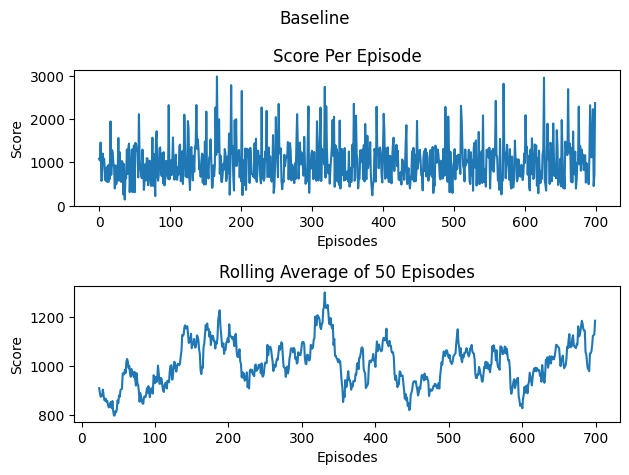

In [30]:
df_baseline = pd.DataFrame(columns=['episode', 'score'])
df_baseline = baseline(df_baseline)
graph(df_baseline, 'Baseline')
del df_baseline

In [25]:
df_deep_q = pd.DataFrame(columns=['episode', 'score'])
df_fixed_targets = pd.DataFrame(columns=['episode', 'score'])
df_double_dqn = pd.DataFrame(columns=['episode', 'score'])

Episode: 102, Steps: 144, Score: 948, eps: 0.788

Episode: 700, Steps: 238, Score: 728, eps: 0.123

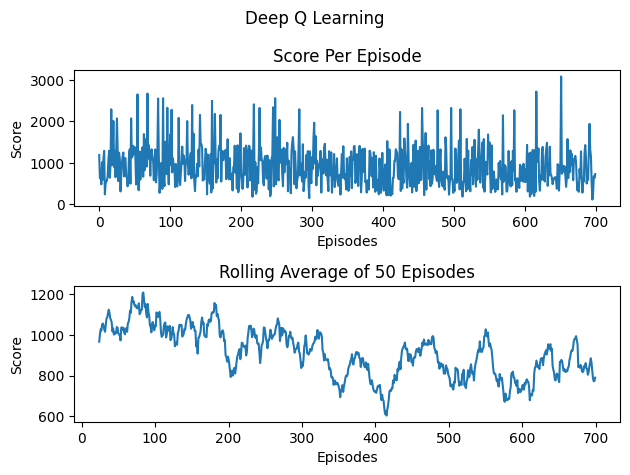

In [26]:
df_deep_q = deep_q_train(df_deep_q)
graph(df_deep_q, 'Deep Q Learning')
del df_deep_q

Episode: 700, Steps: 305, Score: 668, eps: 0.123

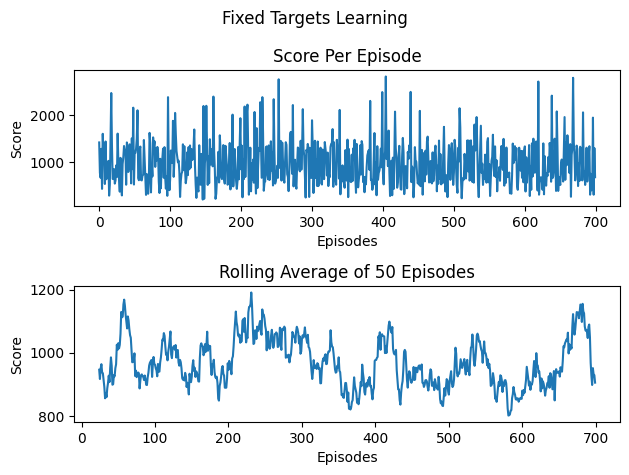

In [28]:
df_fixed_targets = fixed_targets_train(df_fixed_targets)
graph(df_fixed_targets, 'Fixed Targets Learning')
del df_fixed_targets

Episode: 700, Steps: 186, Score: 476, eps: 0.123

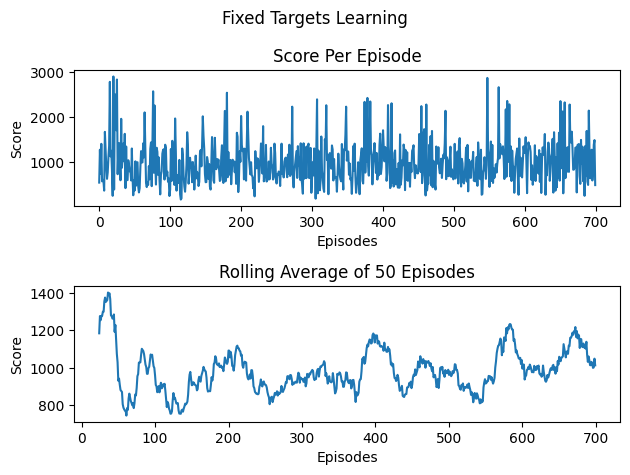

In [31]:
df_double_dqn = double_dqn_train(df_double_dqn)
graph(df_double_dqn, 'Double DQN Learning')
del df_double_dqn

### Conclusions:
- Reinforcement Learning is *hard*. There are no to very little straight forward approaches to training and a lot of things can go wrong (e.g At some point the agent learned to play forever by selecting moves that didn't change the board). The huge sensitivity to hyperparameters also accounts for a big part of RL's difficulty. In the end, a deep understanding of the methodology and the environment, as well as reliable hardware are prerequisites for anyone discovering the field of RL.
- Others' Works:
 - https://github.com/navjindervirdee/2048-deep-reinforcement-learning
 - https://arxiv.org/abs/2110.10374
- Further Research: A promising approach to RL I would be interested in exploring further, regarding the 2048 problem is *In-Dream Learning* using [World Models](https://arxiv.org/abs/1803.10122)